In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#Used to save and load models. Speculated to be faster for large models in
#https://machinelearningmastery.com/save-gradient-boosting-models-xgboost-python/
import joblib
#LightGBM itself
import lightgbm as lgb

Note that classes/tools from sklearn are imported when needed

In [3]:
from IML2018_tools import *

In [4]:
!python --version

Python 3.6.4 :: Anaconda, Inc.


In [5]:
!ls

conda_env.list		Feature_Extraction.ipynb  README.md
EDA_and_lightgbm.ipynb	IML2018_tools.py	  Test_file_content.ipynb
EDA_and_xgboost.ipynb	Prepare_Submission.ipynb
Evaluate_Models.ipynb	__pycache__


In [6]:
#train_file_name = 'train10000.npy'
train_file_name = '/eos/user/m/mlisovyi/IML_challenge_2018/train_full_Nhardest5.pickle'

Read in the file properly for different file formats

In [7]:
train_df = loadInputAsDF(train_file_name, n = None)

In [8]:
train_df.shape

(1042167, 53)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042167 entries, 0 to 1042166
Data columns (total 53 columns):
genjet_sd_m              1042167 non-null float32
recojet_pt               1042167 non-null float32
recojet_eta              1042167 non-null float32
recojet_phi              1042167 non-null float32
recojet_m                1042167 non-null float32
recojet_sd_pt            1042167 non-null float32
recojet_sd_eta           1042167 non-null float32
recojet_sd_phi           1042167 non-null float32
recojet_sd_m             1042167 non-null float32
n_constituents           1042167 non-null int32
sum_charge               1042167 non-null float64
sum_Eem                  1042167 non-null float64
sum_Ehad                 1042167 non-null float64
constituents_pt_0        1042167 non-null float32
constituents_pt_1        1042167 non-null float32
constituents_pt_2        1042167 non-null float32
constituents_pt_3        1042167 non-null float32
constituents_pt_4        1042167 non-nu

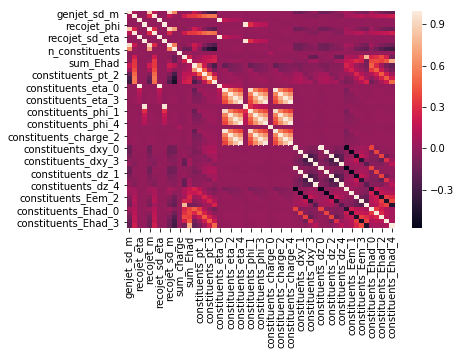

In [10]:
sns.heatmap(train_df.corr())

## EDA

/afs/cern.ch/work/m/mlisovyi/miniconda3/envs/iml2018/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


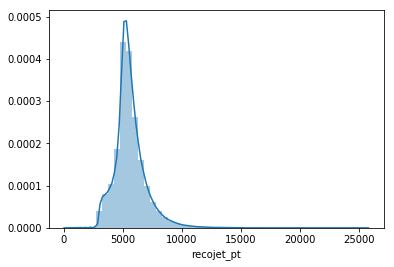

In [11]:
sns.distplot(train_df['recojet_pt'])

In [12]:
#for var in ['recojet_pt', 'recojet_eta', 'recojet_phi', 'recojet_m',
#       'recojet_sd_pt', 'recojet_sd_eta', 'recojet_sd_phi', 'recojet_sd_m',
#       'n_constituents']:
#    print(var)
#    sns.jointplot(x='genjet_sd_m', y=var, data=train_df, kind='hex')

### Feature engineering (done in a dedicated notebook now) and drop some columns

In [13]:
dropColumns(train_df, printColumns=True)

Index(['genjet_sd_m', 'recojet_pt', 'recojet_eta', 'recojet_phi', 'recojet_m',
       'recojet_sd_pt', 'recojet_sd_eta', 'recojet_sd_phi', 'recojet_sd_m',
       'n_constituents', 'sum_charge', 'sum_Eem', 'sum_Ehad',
       'constituents_pt_0', 'constituents_pt_1', 'constituents_pt_2',
       'constituents_pt_3', 'constituents_pt_4', 'constituents_eta_0',
       'constituents_eta_1', 'constituents_eta_2', 'constituents_eta_3',
       'constituents_eta_4', 'constituents_phi_0', 'constituents_phi_1',
       'constituents_phi_2', 'constituents_phi_3', 'constituents_phi_4',
       'constituents_charge_0', 'constituents_charge_1',
       'constituents_charge_2', 'constituents_charge_3',
       'constituents_charge_4', 'constituents_dxy_0', 'constituents_dxy_1',
       'constituents_dxy_2', 'constituents_dxy_3', 'constituents_dxy_4',
       'constituents_dz_0', 'constituents_dz_1', 'constituents_dz_2',
       'constituents_dz_3', 'constituents_dz_4', 'constituents_Eem_0',
       'constituent

### Split and normalise

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('genjet_sd_m', axis=1), train_df['genjet_sd_m'] , test_size=0.30, random_state=314)

## Run only if you want to keep jets between 5 and 7 TeV in the test sample

In [16]:
#Xtest5to7 = (X_test['recojet_pt'] > 5000) & (X_test['recojet_pt'] < 7000)

In [ ]:
#X_test = X_test[Xtest5to7]
#y_test = y_test[Xtest5to7]

In [ ]:
sns.heatmap(X_train.corr())

In [ ]:
from sklearn.decomposition import PCA
pca_trans = PCA()
pca_trans.fit(X_train)
X_train_pca = pca_trans.transform(X_train)
X_test_pca = pca_trans.transform(X_test)

In [ ]:
sns.heatmap(pd.DataFrame(X_test_pca).corr())

# LightGBM regressor

## Build the LightGBM model and define the metric

In [44]:
#preliminary parameters. will be fine-tuned in the GridSearch
lgb_params = {'max_depth': 11, 'learning_rate':0.1, 'n_estimators':100,
              'num_leaves': 500, 'colsample_bytree': 0.8,  
              'reg_alpha': 1e-05, 'reg_lambda': 1,
              'silent':1, 'random_state': 314, 'seed': 314, 'n_jobs':1}

In [45]:
clf = lgb.LGBMRegressor(**lgb_params)

In [46]:
clf.set_params(**lgb_params)

13.3 µs ± 363 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [48]:
#clf.set_params(**lgb_params)
clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_names=['validation_0', 'validation_1'],
        eval_metric=evaluate_loss_lgb,
        verbose=True)

[1]	validation_0's l2: 59222.8	validation_0's xxx: 3.01487	validation_1's l2: 59326.4	validation_1's xxx: 3.00613
[2]	validation_0's l2: 49423.4	validation_0's xxx: 2.56746	validation_1's l2: 49532.5	validation_1's xxx: 2.56345
[3]	validation_0's l2: 41403.5	validation_0's xxx: 2.23067	validation_1's l2: 41520.3	validation_1's xxx: 2.22982
[4]	validation_0's l2: 34868.2	validation_0's xxx: 1.96812	validation_1's l2: 34996.7	validation_1's xxx: 1.96849
[5]	validation_0's l2: 29554.3	validation_0's xxx: 1.76027	validation_1's l2: 29689.1	validation_1's xxx: 1.7604
[6]	validation_0's l2: 25229.5	validation_0's xxx: 1.59104	validation_1's l2: 25383.6	validation_1's xxx: 1.59133
[7]	validation_0's l2: 21704.5	validation_0's xxx: 1.45063	validation_1's l2: 21881.4	validation_1's xxx: 1.45211
[8]	validation_0's l2: 18835.1	validation_0's xxx: 1.3329	validation_1's l2: 19034.8	validation_1's xxx: 1.33355
[9]	validation_0's l2: 16505.9	validation_0's xxx: 1.23211	validation_1's l2: 16733.4	vali

[72]	validation_0's l2: 5348.51	validation_0's xxx: 0.565149	validation_1's l2: 6577.02	validation_1's xxx: 0.578882
[73]	validation_0's l2: 5341.46	validation_0's xxx: 0.565416	validation_1's l2: 6576.81	validation_1's xxx: 0.579212
[74]	validation_0's l2: 5332.34	validation_0's xxx: 0.565212	validation_1's l2: 6577.39	validation_1's xxx: 0.578933
[75]	validation_0's l2: 5320.55	validation_0's xxx: 0.565534	validation_1's l2: 6576.41	validation_1's xxx: 0.579255
[76]	validation_0's l2: 5311.55	validation_0's xxx: 0.565621	validation_1's l2: 6575.58	validation_1's xxx: 0.579513
[77]	validation_0's l2: 5301.39	validation_0's xxx: 0.565439	validation_1's l2: 6575.91	validation_1's xxx: 0.579328
[78]	validation_0's l2: 5288.02	validation_0's xxx: 0.565784	validation_1's l2: 6576.49	validation_1's xxx: 0.579985
[79]	validation_0's l2: 5277.8	validation_0's xxx: 0.565738	validation_1's l2: 6575.5	validation_1's xxx: 0.580079
[80]	validation_0's l2: 5267.5	validation_0's xxx: 0.566155	valida

[43]	validation_0's l2: 5733.42	validation_0's xxx: 0.567461	validation_1's l2: 6624.64	validation_1's xxx: 0.577876
[44]	validation_0's l2: 5713.03	validation_0's xxx: 0.566713	validation_1's l2: 6618.83	validation_1's xxx: 0.577161
[45]	validation_0's l2: 5694.96	validation_0's xxx: 0.565995	validation_1's l2: 6615.47	validation_1's xxx: 0.576409
[46]	validation_0's l2: 5676.88	validation_0's xxx: 0.565634	validation_1's l2: 6611.16	validation_1's xxx: 0.576359
[47]	validation_0's l2: 5662.23	validation_0's xxx: 0.565318	validation_1's l2: 6607.14	validation_1's xxx: 0.575712
[48]	validation_0's l2: 5645.4	validation_0's xxx: 0.564965	validation_1's l2: 6605.42	validation_1's xxx: 0.575547
[49]	validation_0's l2: 5628.75	validation_0's xxx: 0.564735	validation_1's l2: 6602.49	validation_1's xxx: 0.575568
[50]	validation_0's l2: 5616.2	validation_0's xxx: 0.564294	validation_1's l2: 6599.25	validation_1's xxx: 0.575261
[51]	validation_0's l2: 5603.32	validation_0's xxx: 0.564187	valid

[14]	validation_0's l2: 9964.19	validation_0's xxx: 0.909061	validation_1's l2: 10314.7	validation_1's xxx: 0.913457
[15]	validation_0's l2: 9262.37	validation_0's xxx: 0.86482	validation_1's l2: 9637.48	validation_1's xxx: 0.868346
[16]	validation_0's l2: 8691.27	validation_0's xxx: 0.826302	validation_1's l2: 9088.19	validation_1's xxx: 0.830793
[17]	validation_0's l2: 8220.32	validation_0's xxx: 0.793096	validation_1's l2: 8644.32	validation_1's xxx: 0.797927
[18]	validation_0's l2: 7832.93	validation_0's xxx: 0.764427	validation_1's l2: 8279.25	validation_1's xxx: 0.768983
[19]	validation_0's l2: 7510.37	validation_0's xxx: 0.739176	validation_1's l2: 7983.63	validation_1's xxx: 0.743841
[20]	validation_0's l2: 7261.44	validation_0's xxx: 0.721491	validation_1's l2: 7760.99	validation_1's xxx: 0.726331
[21]	validation_0's l2: 7038.58	validation_0's xxx: 0.700833	validation_1's l2: 7559.51	validation_1's xxx: 0.706034
[22]	validation_0's l2: 6854.02	validation_0's xxx: 0.683664	vali

[85]	validation_0's l2: 5229.63	validation_0's xxx: 0.565399	validation_1's l2: 6573.36	validation_1's xxx: 0.580057
[86]	validation_0's l2: 5217.91	validation_0's xxx: 0.5654	validation_1's l2: 6572.99	validation_1's xxx: 0.580373
[87]	validation_0's l2: 5209.73	validation_0's xxx: 0.5654	validation_1's l2: 6573.23	validation_1's xxx: 0.580315
[88]	validation_0's l2: 5200.23	validation_0's xxx: 0.565254	validation_1's l2: 6572.86	validation_1's xxx: 0.580642
[89]	validation_0's l2: 5190.61	validation_0's xxx: 0.565191	validation_1's l2: 6572.96	validation_1's xxx: 0.580612
[90]	validation_0's l2: 5179.68	validation_0's xxx: 0.565146	validation_1's l2: 6572.62	validation_1's xxx: 0.580646
[91]	validation_0's l2: 5171.45	validation_0's xxx: 0.565027	validation_1's l2: 6571.31	validation_1's xxx: 0.580419
[92]	validation_0's l2: 5163.69	validation_0's xxx: 0.564827	validation_1's l2: 6570.61	validation_1's xxx: 0.580147
[93]	validation_0's l2: 5157.15	validation_0's xxx: 0.564673	validat

In [36]:
clf.evals_result_.keys()

dict_keys(['validation_0', 'validation_1'])

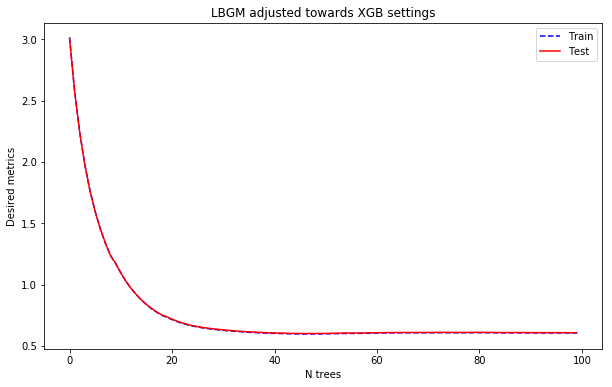

In [27]:
plotClfPerfEvolution(clf, title='LBGM adjusted towards XGB settings')

In [43]:
y_pred = clf.predict(X_test)
evaluate_loss(y_pred, y_test)

1.512289424038849

# EVERYTHING BELOW WAS NOT TESTED YET

## Do a comparison of feature importance and extract the optimal number of trees

In [ ]:
modelfit(clf, X_train, y_train, early_stopping_rounds=10)

## GridSearch to determine the optimal parameters

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.metrics import make_scorer

The next cell is CPU intense! do not try it on the full dataset!!!!!

In [ ]:
param_test1 = {'max_depth': [3,5,7],
               'min_child_weight': [1,3],
               'gamma': [0,1e-3,1e-1],
               'subsample': [0.6,0.8,1],
               'colsample_bytree':[0.6,0.8,1],
               'reg_alpha':[0, 1e-3, 1e-1],
               'reg_lambda':[1, 1e-1, 1e-3]}
gs1 = GridSearchCV(estimator=clf, param_grid=param_test1, 
                   scoring=make_scorer(evaluate_loss, greater_is_better=False),
                   n_jobs=4, cv=5)
gs1.fit(X_train, y_train)
print(gs1.best_params_)
print(gs1.best_score_)
print(gs1.grid_scores_)

In [ ]:
gs1.cv_results_

In [ ]:
cv_results=[]

In [ ]:
param_test_list = [{'max_depth': [3,5,7],
               'min_child_weight': [1,3]},
               {'gamma': [0,1e-3,1e-1]},
               {'subsample': [0.6,0.8,1],
               'colsample_bytree':[0.6,0.8,1]},
               {'reg_alpha':[0, 1e-3, 1e-1],
               'reg_lambda':[1, 1e-1, 1e-3]}]
for param_test in param_test_list:
    gs1 = GridSearchCV(estimator=clf, param_grid=param_test, 
                       scoring=make_scorer(evaluate_loss, greater_is_better=False),
                       n_jobs=4, cv=5,
                       verbose=True)
    gs1.fit(X_train, y_train)
    print(gs1.best_params_)
    print(gs1.best_score_)
    cv_results.append(gs1.cv_results_)
    #print(gs1.cv_results_)
    clf.set_params(**(gs1.best_params_))

## Save the optimised clf object

In [ ]:
#joblib.dump(gs1, "gs1_2it.joblib.dat")

In [ ]:
xgb_opt_ref1 = gs1.best_estimator_.get_params()
xgb_opt_ref1

## Second iteration of GS

In [ ]:
param_test_list = [{'max_depth': [7, 9, 11],
               'min_child_weight': [1,3]},
               {'gamma': [0,1e-3,1e-1]},
               {'reg_alpha':[0, 1e-5],
               'reg_lambda':[1, 0.5,2]}]
clf.set_params(**xgb_opt_ref1)
for param_test in param_test_list:
    gs1 = GridSearchCV(estimator=clf, param_grid=param_test, 
                       scoring=make_scorer(evaluate_loss, greater_is_better=False),
                       n_jobs=4, cv=3,
                       verbose=True)
    gs1.fit(X_train, y_train)
    print(gs1.best_params_)
    print(gs1.best_score_)
    clf.set_params(**(gs1.best_params_))

## PCA train

In [ ]:
param_test_list = [{'max_depth': [5, 7, 9, 11]},
               {'min_child_weight': [1,3]},
               {'gamma': [0,1e-3,1e-1]},
               {'reg_alpha':[0, 1e-5],
               'reg_lambda':[1]}]
clf.set_params(**xgb_opt_ref1)
for param_test in param_test_list:
    gs2 = GridSearchCV(estimator=clf, param_grid=param_test, 
                       scoring=make_scorer(evaluate_loss, greater_is_better=False),
                       n_jobs=4, cv=3,
                       verbose=True)
    gs2.fit(X_train_pca, y_train)
    print(gs2.best_params_)
    print(gs2.best_score_)
    clf.set_params(**(gs2.best_params_))

In [ ]:
#joblib.dump(gs2, "gs2.joblib.dat")